<a href="https://colab.research.google.com/github/zqiaohe/100daysofcode/blob/master/CupIt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Стемминг данных](https://)

##Загрузка данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np

%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from nltk.corpus import stopwords

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [0]:
train = pd.read_csv('drive/My Drive/CupITdatasets/Classification/feed_train.csv')
test = pd.read_csv('drive/My Drive/CupITdatasets/Classification/feed_test.csv')

Кредит                         0.381816
Вклад                          0.144137
Ипотека                        0.114523
Бизнес услуги                  0.100754
Обслуживание физ. и юр. лиц    0.090700
Дебетовая карта                0.078024
Реструктуризация               0.058791
Денежные переводы              0.022730
Инвестиционные продукты        0.008524
Name: type, dtype: float64

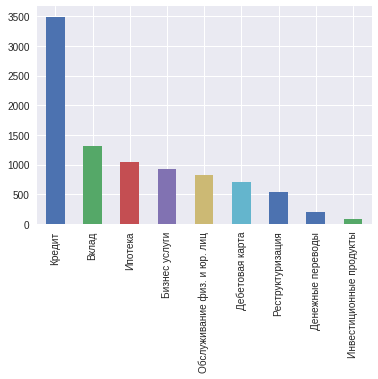

In [8]:
display(train.type.value_counts()/train.type.shape)
train.type.value_counts().plot.bar()

In [0]:
tf_idf = TfidfVectorizer(ngram_range=(1, 4), stop_words=stopwords.words('russian'), 
                         #tokenizer=None,
                         #preprocessor=None,
                         analyzer='word',
                         max_df=0.8, 
                         min_df=8,
                         #max_features=10000
                        )

In [0]:
tf_idf_model = tf_idf.fit(np.concatenate([train['text'].values.astype('U'), test['text'].values.astype('U')]))

In [20]:
%%time
train_tf_idf_vec = tf_idf_model.transform(train['text'].values.astype('U'))
test_tf_idf_vec = tf_idf_model.transform(test['text'].values.astype('U'))

CPU times: user 4.88 s, sys: 13.7 ms, total: 4.89 s
Wall time: 4.89 s


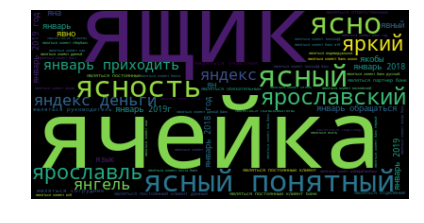

In [21]:
wordcloud = WordCloud().generate_from_frequencies(tf_idf_model.vocabulary_)

# Display the generated image:
plt.figure() 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.tight_layout()
plt.show() 

In [0]:
lm = LogisticRegression(#solver='newton-cg', 
                        #n_jobs=-1,
                        #solver='lbfgs',
                        penalty='l2',
                        #tol=0.000000001,
                        random_state=42,
                        C=10, 
                        max_iter=100000)

In [0]:
lm_params = {'penalty':['l1', 'l2'],
             'C':[0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 100],
             #'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             #'tol' : [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.0001]
    
    
}
lm_search = GridSearchCV(estimator=lm, 
                         param_grid=lm_params, 
                         scoring ='accuracy', 
                         cv=StratifiedKFold(10), 
                         n_jobs=-1,
                         verbose=1)

In [23]:
%%time
lm_search_fitted = lm_search.fit(X=train_tf_idf_vec, y=pd.factorize(train.type)[0])

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 2.53 s, sys: 200 ms, total: 2.73 s
Wall time: 5min 19s


In [24]:
lm_search_fitted.best_estimator_

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
%%time
pred_scores = cross_val_score(estimator=lm_search_fitted.best_estimator_, X=train_tf_idf_vec, y=pd.factorize(train.type)[0],
                scoring='accuracy',  
                cv=10, #stratified by default
                n_jobs=-1)
display(np.mean(pred_scores))

0.7040798184536059

CPU times: user 56.5 ms, sys: 8.13 ms, total: 64.6 ms
Wall time: 14.3 s


In [0]:
predicts = lm_search_fitted.best_estimator_.predict(test_tf_idf_vec)
predicts_names = pd.factorize(train.type)[1][predicts]

In [0]:
submission = pd.DataFrame({'index': range(0, len(predicts)),
                    'type': predicts_names})
submission .to_csv('multiclass_sample_submission.csv', index=False)

##Keras и Word2Vec

In [28]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.7.1)


In [0]:
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from gensim.models import word2vec

In [0]:
from nltk.tokenize import ToktokTokenizer

In [0]:
tok =  ToktokTokenizer()

In [0]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [0]:
train['tokenize_text'] = [tok.tokenize(tokens) for tokens in train['text']]

In [0]:
test['tokenize_text'] = [tok.tokenize(tokens) for tokens in test['text']]

In [0]:
testmodel = word2vec.Word2Vec(test['tokenize_text'], size=300, window=3, workers=4)
model = word2vec.Word2Vec(train['tokenize_text'], size=300, window=3, workers=4)

In [43]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))
testw2v = dict(zip(testmodel.wv.index2word,testmodel.wv.syn0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [0]:
testmodel = word2vec.Word2Vec(test['tokenize_text'], size=300, window=3, workers=4)
model = word2vec.Word2Vec(train['tokenize_text'], size=300, window=3, workers=4)

In [0]:
train_mean=mean_vectorizer(w2v).fit(train['tokenize_text']).transform(train['tokenize_text'])
test_mean=mean_vectorizer(testw2v).fit(test['tokenize_text']).transform(test['tokenize_text'])

In [0]:
dtrain = mean_vectorizer(w2v).fit(train['tokenize_text']).transform(train['tokenize_text'])
dtest = mean_vectorizer(w2v).fit(train['tokenize_text']).transform(train['tokenize_text'])

In [0]:
train['type'] = train.type.astype('category').cat.codes

In [74]:
def split(train,y,ratio):
    idx = round(train.shape[0] * ratio)
    return train[:idx, :], train[idx:, :], y[:idx], y[idx:]
y = train['type']
Xtr, Xval, ytr, yval = split(dtrain, y,0.9)
Xtr.shape,Xval.shape,ytr.mean(),yval.mean()

((8236, 300), (915, 300), 4.369232637202526, 4.389071038251366)

In [75]:
# подключим библиотеки keras 
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.preprocessing.text import Tokenizer
from keras import regularizers

Using TensorFlow backend.


In [76]:
# опишем нейронную сеть
model = Sequential()
model.add(Dense(128, input_dim=(Xtr.shape[1])))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
history = model.fit(Xtr, ytr,
                    batch_size=64,
                    epochs=500,
                    validation_data=(Xval, yval),
                    class_weight='auto',
                    verbose=0)

In [0]:
from sklearn.metrics import accuracy_score

In [101]:
%%time
classes = model.predict(Xval, batch_size=128)
print(accuracy_score(yval, classes))

0.13879781420765028
CPU times: user 12.1 ms, sys: 9.28 ms, total: 21.4 ms
Wall time: 19.2 ms


In [0]:
import xgboost as xgb

In [0]:
ddtest = xgb.DMatrix(dtrain)

In [0]:
dtr = xgb.DMatrix(Xtr, label= ytr,missing = np.nan)
dval = xgb.DMatrix(Xval, label= yval,missing = np.nan)

watchlist = [(dtr, 'train'), (dval, 'eval')]
history = dict()

In [0]:
def modelfit(alg, Xtr, ytr,useTrainCV=True, cv_folds=5):
  xgb1 = xgb.sklearn.XGBClassifier(
  learning_rate =0.1,
  n_estimators=50,
  max_depth=5,
  min_child_weight=1,
  gamma=0,
   subsample=0.8,
  colsample_bytree=0.8,
  objective='multi:softmax',
  nthread=4,
 scale_pos_weight=1,
 seed=27)def modelfit(alg, train_data_features, train_labels,useTrainCV=True, cv_folds=5):

    if useTrainCV:
        params=alg.get_xgb_params()
        xgb_param=dict([(key,[params[key]]) for key in params])

        boost = xgb.sklearn.XGBClassifier()
        cvresult = GridSearchCV(boost,xgb_param,cv=cv_folds)
        cvresult.fit(X,y)
        alg=cvresult.best_estimator_


    #Fit the algorithm on the data
    alg.fit(train_data_features, train_labels)

    #Predict training set:
    dtrain_predictions = alg.predict(train_data_features)
    dtrain_predprob = alg.predict_proba(train_data_features)[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % sklearn.metrics.accuracy_score(train_labels, dtrain_predictions))

xgb1 = xgb.sklearn.XGBClassifier(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=27)    


X=np.random.normal(size=(200,30))
y=np.random.randint(0,5,200)

modelfit(xgb1, X, y)

In [0]:
params = {
    'learning_rate': 0.1,
    'max_depth': 66,
    'eta': 0.025,
    'nthread': 4,
    'subsample': 0.85,
    'colsample_bytree':0.8,
    'objective': 'multi:softmax',
    'num_class':9,
    'colsample_bytree': 0.4,
    'min_child_weight': 10,
    'scale_pos_weight':(1)/y.mean(),
    'seed':27,
    'eval_metric': ['mlogloss'],
}


In [0]:
model_new = xgb.train(params, dtr, num_boost_round=100, evals=watchlist,verbose_eval=10)

[0]	train-mlogloss:2.03682	eval-mlogloss:2.07118
[10]	train-mlogloss:1.22038	eval-mlogloss:1.51484


In [139]:
%%time
classes = model_new.predict(dval)
print(accuracy_score(yval, classes))

0.5912568306010929
CPU times: user 2.16 ms, sys: 996 µs, total: 3.16 ms
Wall time: 3.95 ms
